<a href="https://colab.research.google.com/github/vopstalf/ML-Training-TE/blob/main/XGBOOST_Excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Beginner Workshop: XGBoost for Predictive Maintenance (CMAPSS)

**Goal:**
- Learn the basics of XGBoost
- Train a regression model for real data
- Do simple hyperparameter tuning
- Understand predictions using SHAP

This notebook was created by Filip Van Opstal.

---

## 0. Setup (run this first)


In [ ]:
!pip install -q xgboost shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

---

## 1. Problem Description

We use the **NASA CMAPSS dataset**, a real industrial dataset for:
- Gas turbines
- Compressors
- Rotating equipment

The dataset is a widely used benchmark for estimating the Remaining Useful Life (RUL) of aircraft turbofan engines. It consists of simulated run-to-failure trajectories generated using a high-fidelity Matlab Simulink model.

The dataset can be consulted at [NASA Prognostics Data Repository](https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/)

🎯 **Task:** predict **Remaining Useful Life (RUL)** from sensor data.

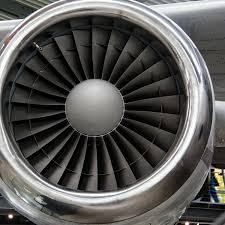
---

---

## 2. Load the CMAPSS Dataset & Selecting Features

In [ ]:
# Column names from NASA specification
cols = (
    ["engine_id", "cycle"] +
    [f"setting{i}" for i in range(1, 4)] +
    [f"sensor{i}" for i in range(1, 22)]
)

# Load training data
train = pd.read_csv(
    "https://raw.githubusercontent.com/mapr-demos/predictive-maintenance/refs/heads/master/notebooks/jupyter/Dataset/CMAPSSData/train_FD001.txt",
    sep=r"\s+",
    header=None,
    names=cols
).dropna(axis=1)

train.head()

,engine_id,cycle,setting1,setting2,setting3,...,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,...,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,...,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,...,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,...,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,...,393,2388,100.0,38.90,23.4044


**CMAPSS Data Dictionary**

The dataset represents a simulation of a turbofan engine (like those on a commercial jet) degrading over time.
1. Identifiers (The Basics)
engine_id: A unique ID for each engine in the fleet. In this dataset, we follow each engine from its "healthy" state until it eventually fails.
cycle: The "Time" unit. One cycle represents one full flight (Takeoff
→
→
 Cruise
→
→
 Landing).
2. Operational Settings (The Environment)
These describe the external conditions the engine is operating in (the "Inputs"):
setting1: Altitude.
setting2: Mach Number (Flight speed).
setting3: Throttle Resolver Angle (TRA) — essentially how much "gas" the pilot is giving the engine.
Note: In dataset FD001, these are mostly constant because all engines are flying at sea level.
3. Sensor Measurements (The Health Signals)
These 21 sensors measure the engine's internal reaction to wear and tear (the "Outputs"). They generally fall into three categories:
Temperatures: Measurements at different stages (Inlet, Fan, Low-Pressure Turbine, High-Pressure Turbine).
Example: As an engine wears out, it often has to run "hotter" to produce the same thrust.
Pressures: Static and total pressure at various engine stages.
Example: Pressure drops can indicate leaks or inefficiencies in the compressor.
Speeds & Flows:
Physical/Corrected Speeds: How fast the Fan (Nf) and Core (Nc) are spinning.
Fuel Flow: How much fuel is being burned.
Bleed Air: Air taken from the engine for cabin pressure/cooling.

Before feeding data into XGBoost, it is crucial to understand which features provide information and which provide noise. XGBoost handles many features well, but "dead" features (those that never change) waste computation and can slightly degrade performance.

**Goal**: Identify sensors that are "constant" (they don't change over time) and sensors that are highly correlated with the "Cycle" (engine age).

1.   Find the "Flatliners": Calculate the Standard Deviation (std()) for all sensor columns. Identify which sensors have a standard deviation of 0.
2.   Visualizing Degradation: Pick one engine (e.g., engine_id == 1) and plot sensor11 vs. cycle and sensor1 vs. cycle. Normalize the data for better numerical performance and to avoid sensor readings with higher numerical value to be artifically considered more important. *Question: Which sensor looks like a better "feature" for a gradient boosting model to predict Remaining Useful Life (RUL)?*

2.   The Correlation Heatmap: Create a correlation matrix for the sensors.
Task: Find two sensors that are highly correlated (e.g., > 0.95).
XGBoost Tip: While XGBoost is robust to multicollinearity, keeping highly redundant features can make the "Feature Importance" scores misleading.




In [ ]:
# Task 1: Find constant sensors
stats = train.describe().T
constant_sensors = stats[stats['std'] == 0].index.tolist()
print(f"Constant sensors to drop: {constant_sensors}")

Constant sensors to drop: ['setting3', 'sensor18', 'sensor19']


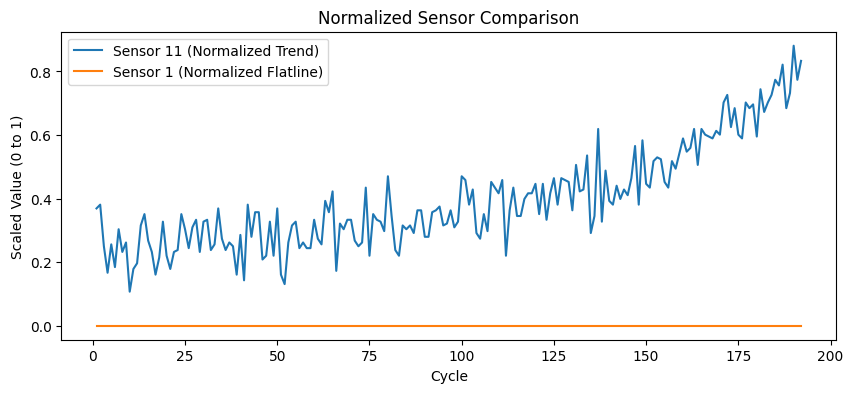

In [ ]:
# Task 2: Visualizing
# Create a copy for visualization and normalization
train_norm = train.copy()

# We create a scaled version so all sensor values are between 0 and 1
scaler = MinMaxScaler()

# Scale only the sensor columns
sensor_cols = [f"sensor{i}" for i in range(1, 22) if f"sensor{i}" in train.columns]
train_norm[sensor_cols] = scaler.fit_transform(train[sensor_cols])

# Plot the normalized data
engine1_norm = train_norm[train_norm['engine_id'] == 1]

plt.figure(figsize=(10, 4))
plt.plot(engine1_norm['cycle'], engine1_norm['sensor11'], label='Sensor 11 (Normalized Trend)')
plt.plot(engine1_norm['cycle'], engine1_norm['sensor1'], label='Sensor 1 (Normalized Flatline)')
plt.ylabel("Scaled Value (0 to 1)")
plt.xlabel("Cycle")
plt.legend()
plt.title("Normalized Sensor Comparison")
plt.show()

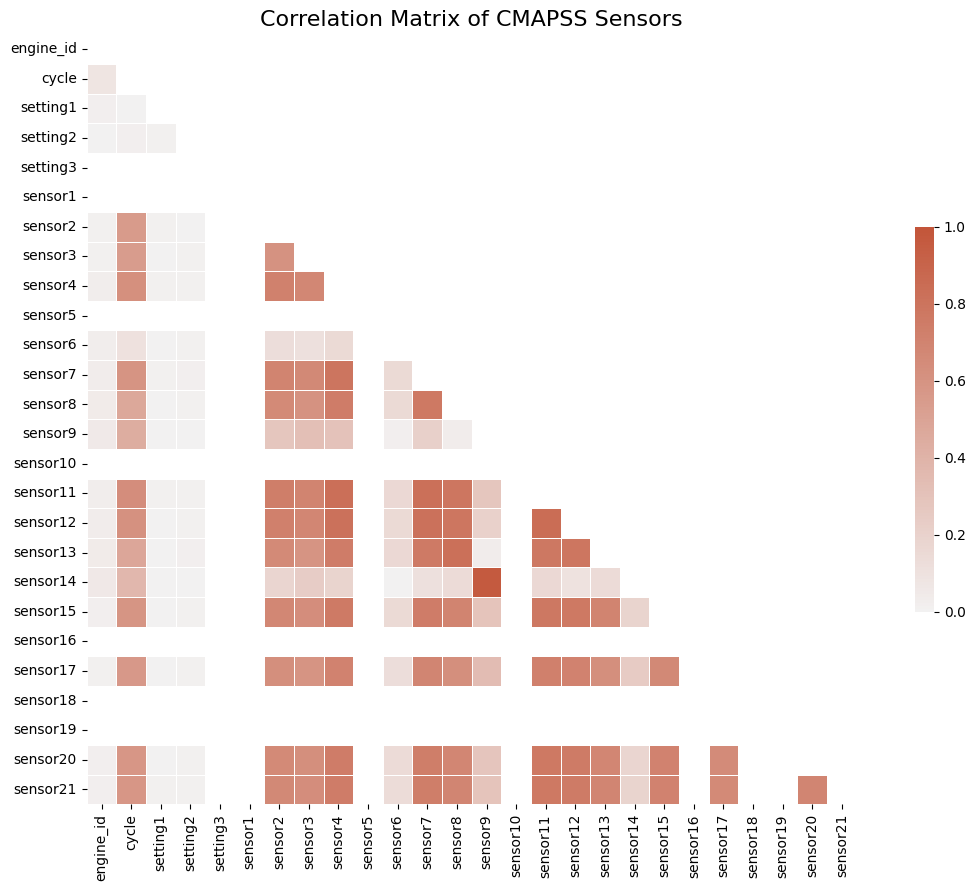

Highly Redundant Sensors (>0.95 correlation): ['sensor14']


In [ ]:
# Task 3: Correlation Heatmap
corr_matrix = train.corr().abs()
plt.figure(figsize=(15, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1.0, vmin=0.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

plt.title("Correlation Matrix of CMAPSS Sensors", fontsize=16)
plt.show()

# We drop columns with a correlation greater than 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Highly Redundant Sensors (>0.95 correlation): {to_drop}")

We drop the constant sensor columns and highly correlated features, to obtain our final set of features. We will consider the settings columns as well.

Remember, in the NASA CMAPSS dataset, the three "setting" columns represent the Operating Conditions of the engine.

Specifically, they are:

*   Setting 1: Altitude (The height at which the plane is flying).
*   Setting 2: Mach Number (The speed of the aircraft relative to the speed of sound).
*   Setting 3: TRA (Throttle Resolver Angle) (How far the pilot has pushed the "gas pedal").



In [ ]:
# Drop constant columns
train_cleaned = train_norm.drop(columns=constant_sensors)

# Drop highly correlated columns
train_reduced = train_cleaned.drop(columns=to_drop)

# Our selected set of features
sensor_cols = [c for c in train_reduced.columns if "sensor" in c]
features = sensor_cols + ["setting1", "setting2", "setting3"]
len(features), features[:5]

(21, ['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5'])

---

## 3. Create Remaining Useful Life (RUL)

We extract the run-to-failure data from the full data table for each engine by grouping per engine ID and computing the number of operating cycles.

In [ ]:
# Compute max cycle per engine
max_cycles = train.groupby("engine_id")["cycle"].transform("max")

# RUL = max cycle - current cycle
train["RUL"] = max_cycles - train["cycle"]

train[["engine_id", "cycle", "RUL"]].head()

,engine_id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


---

## 5. Train / Test Split (by engine)

❗Important since we are dealing with time-series data we don't split the data simply row-wise.

In [ ]:
engine_ids = train["engine_id"].unique()
train_ids, test_ids = train_test_split(
    engine_ids, test_size=0.2, random_state=42
)

train_df = train[train.engine_id.isin(train_ids)]
test_df  = train[train.engine_id.isin(test_ids)]

X_train = train_df[features]
y_train = train_df["RUL"]

X_test = test_df[features]
y_test = test_df["RUL"]

---

## 6. Train a Baseline XGBoost Model

The code below fits the actual XGBOOST model to the data for our selected features.
Some explanation of the various hyperparameters we use:


*   n_estimators=200 (Number of Trees): This tells the model to build 200 trees. *Rule of thumb: More trees allow for more learning, but if this number is too high, the model might "overfit" (memorize the training data instead of learning patterns).*
*   max_depth=3 (Tree Depth): This controls how deep (complex) each individual tree can get. A depth of 3 is relatively "shallow."
*   learning_rate=0.05 (The "Step Size"):
After each tree is built, its contribution is multiplied by this number.
Analogy: If you are walking toward a target, a high learning rate is a "giant leap" (fast but might overshoot), while a low learning rate is a "baby step" (slower but much more precise).
*   subsample=0.8 (Row Sampling):
Before building each tree, XGBoost randomly selects 80% of the engines/rows to look at. Purpose: This prevents the model from becoming too reliant on a few specific "weird" engines in your training set.
*   colsample_bytree=0.8 (Feature Sampling):
For each tree, the model only looks at 80% of your sensors.
Why this helps: Remember our discussion on redundant sensors? This force-chooses different sensors for different trees, ensuring that the model doesn't just focus on one "favorite" sensor and ignores the others.
*   objective="reg:squarederror" (The Goal):
This tells XGBoost that we are doing Regression (predicting a continuous number like "Cycles Remaining") rather than Classification (Yes/No). It minimizes the squared difference between the predicted RUL and the actual RUL.
*   random_state=42 (The Seed):
This ensures that the "random" parts of the model (like subsampling) happen the exact same way every time you run the code. This makes your results reproducible.

❗ Feel free to experiment with the values to see how they affect the final result.


In [ ]:
model = XGBRegressor(
n_estimators=200,
max_depth=3,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
objective="reg:squarederror",
random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

---

## 7. Evaluate Performance

We evaluate the performance of our model on the test set.

RMSE: 35.3
MAE:  26.1


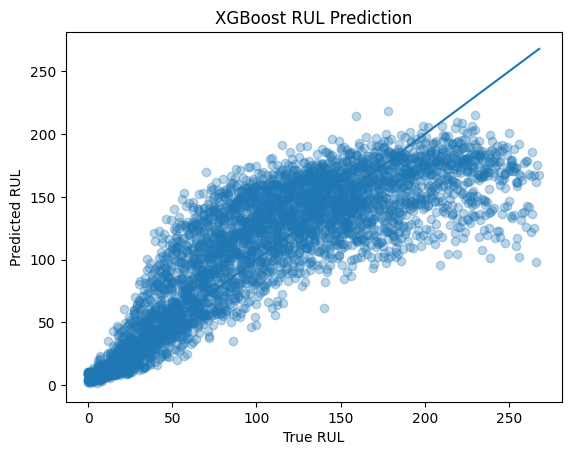

In [ ]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.1f}")
print(f"MAE:  {mae:.1f}")

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, y_test.max()], [0, y_test.max()])
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("XGBoost RUL Prediction")
plt.show()

## 7b. Clipping

By saturating the RUL target at a fixed threshold, we prevent the model from learning distinct values for healthy states, which improves prediction on degrading engines.

In maintenance, we don't care if an engine is "super healthy" or just "healthy." We only care about accuracy when the engine starts dying (e.g., when RUL < 125).

RMSE (Clipped): 17.1
MAE (Clipped):  12.6


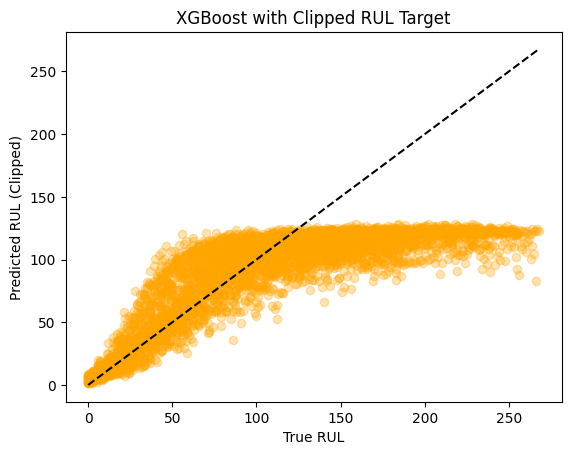

In [ ]:
threshold = 125

# We use .clip() directly on the Series and assign it to a new variable
y_train_clipped = y_train.clip(upper=threshold)

# Re-train the model using the NEW target (y_train_clipped)
model_clipped = XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

model_clipped.fit(X_train, y_train_clipped)

# Predict and Evaluate
y_pred_clipped = model_clipped.predict(X_test)
y_test_clipped_evaluation = y_test.clip(upper=125)

# Compare with the original test values
rmse_new = np.sqrt(mean_squared_error(y_test_clipped_evaluation, y_pred_clipped))
mae_new = mean_absolute_error(y_test_clipped_evaluation, y_pred_clipped)


print(f"RMSE (Clipped): {rmse_new:.1f}")
print(f"MAE (Clipped):  {mae_new:.1f}")

# Visualize the 'Capping' effect
plt.figure()
plt.scatter(y_test, y_pred_clipped, alpha=0.3, color='orange')
plt.plot([0, y_test.max()], [0, y_test.max()], 'k--') # Diagonal line
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL (Clipped)")
plt.title("XGBoost with Clipped RUL Target")
plt.show()

---

## 8. Simple Hyperparameter Tuning

Let's perform some simple hyper-parameter tuning and vary the maximal depth of our decision trees.


In [ ]:
depths = [2, 3, 5, 7]
results = {}

for d in depths:
    m = XGBRegressor(
        n_estimators=200,
        max_depth=d,
        learning_rate=0.05,
        objective="reg:squarederror",
        random_state=42
    )
    m.fit(X_train, y_train_clipped)
    pred = m.predict(X_test)
    y_test_clipped_evaluation = y_test.clip(upper=125)
    results[d] = mean_absolute_error(y_test_clipped_evaluation, pred)

results

{2: 13.197917938232422,
 3: 12.646059036254883,
 5: 12.276534080505371,
 7: 12.318252563476562}

Which trees generalize better?

Let's not investigate the most important features. Do they make sense to you?

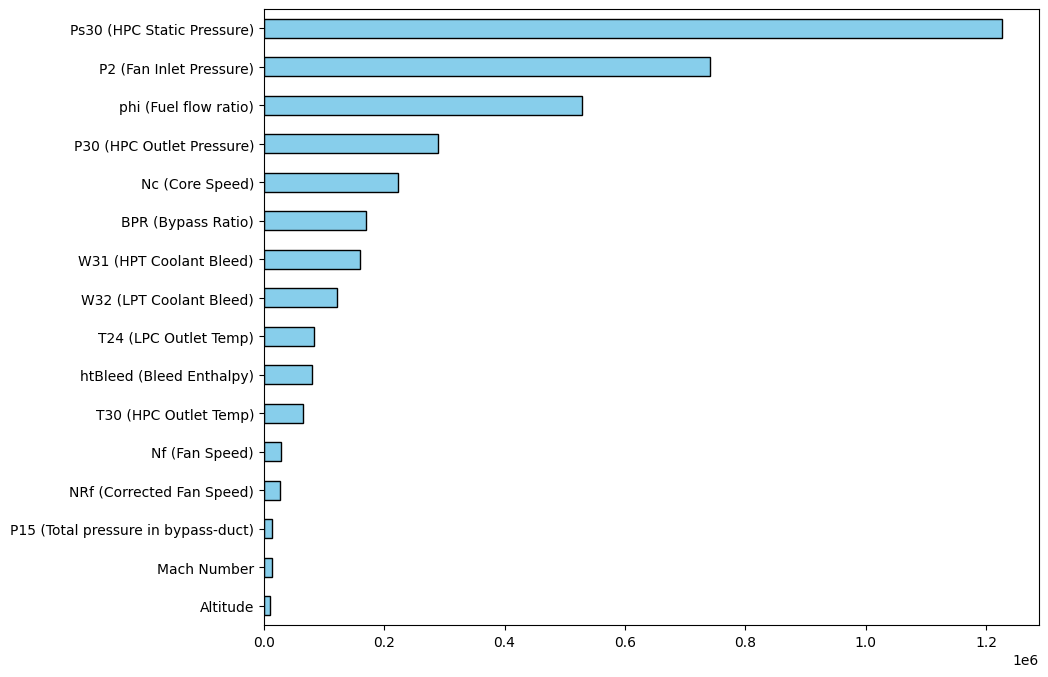

In [ ]:
sensor_labels = {
    "setting1": "Altitude",
    "setting2": "Mach Number",
    "setting3": "Throttle Angle",
    "sensor1": "T2 (Inlet Temp)",
    "sensor2": "T24 (LPC Outlet Temp)",
    "sensor3": "T30 (HPC Outlet Temp)",
    "sensor4": "P2 (Fan Inlet Pressure)",
    "sensor5": "P2 (Pressure at fan inlet)",
    "sensor6": "P15 (Total pressure in bypass-duct)",
    "sensor7": "P30 (HPC Outlet Pressure)",
    "sensor8": "Nf (Fan Speed)",
    "sensor9": "Nc (Core Speed)",
    "sensor10": "Ps15 (By-pass Pressure)",
    "sensor11": "Ps30 (HPC Static Pressure)",
    "sensor12": "phi (Fuel flow ratio)",
    "sensor13": "NRf (Corrected Fan Speed)",
    "sensor14": "NRc (Corrected Core Speed)",
    "sensor15": "BPR (Bypass Ratio)",
    "sensor16": "Burner Fuel-Air Ratio",
    "sensor17": "htBleed (Bleed Enthalpy)",
    "sensor20": "W31 (HPT Coolant Bleed)",
    "sensor21": "W32 (LPT Coolant Bleed)"
}


importance = model.get_booster().get_score(importance_type="gain")
importance_series = pd.Series(importance)
importance_series.index = [sensor_labels.get(x, x) for x in importance_series.index]

importance_series.sort_values().plot(
    kind="barh",
    figsize=(10, 8),
    color='skyblue',
    edgecolor='black'
)
plt.show()

---
## 10. Model Explainability with SHAP

Let's use one of the toolkits related to explainable AI to investigate further our obtained model.

What SHAP does for XAI
Fair Credit: Based on Game Theory, SHAP treats each sensor as a "player" in a game and calculates how much that player contributed to the final "score" (the RUL prediction).
Directional Impact: Unlike basic feature importance (which just tells you if a sensor is "important"), SHAP tells you the direction: "Did high temperature push the predicted life up or down?"
Local vs. Global: It can explain a single flight (Local) or the behavior of the entire engine fleet (Global).



Global Explanation: Which components affect the whole fleet?


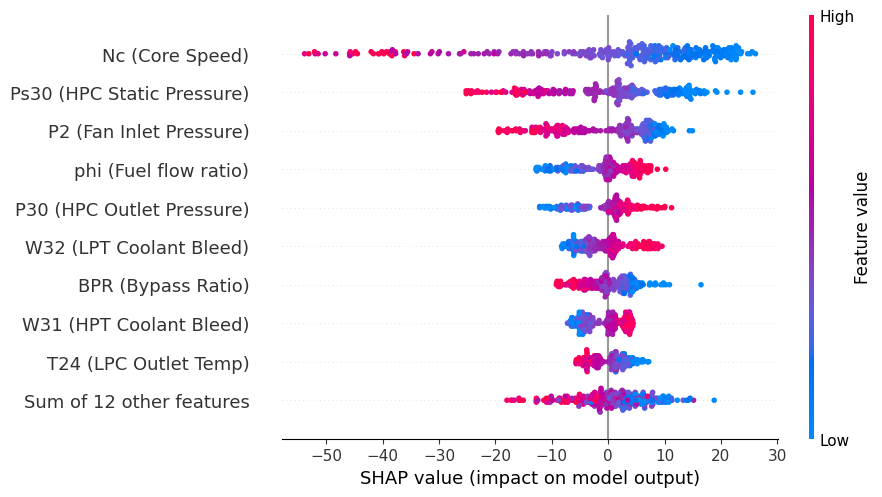


Local Explanation: Why did this specific engine get this RUL prediction?


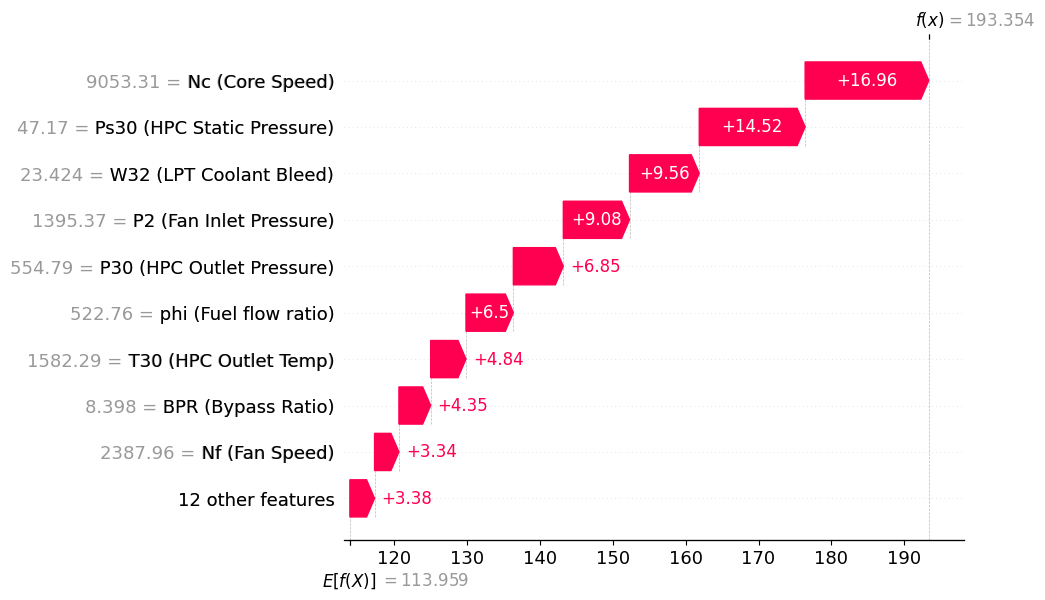

In [ ]:
X_test_readable = X_test.rename(columns=sensor_labels)
explainer = shap.Explainer(model, X_test_readable)
shap_values = explainer(X_test_readable.sample(300))

# Global behavior
print("Global Explanation: Which components affect the whole fleet?")
shap.plots.beeswarm(shap_values)

# Behavior of a specific engine
print("\nLocal Explanation: Why did this specific engine get this RUL prediction?")
shap.plots.waterfall(shap_values[0])